# Multimodal Idiomaticity Representation



## 1) Library and data import

In [ ]:
"""
Installing Required Packages
"""
%pip install git+https://github.com/openai/CLIP.git
%pip install transformers
%pip install numpy pandas scikit-learn
%pip install torch torchvision clip-by-openai numpy pandas scikit-learn

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-kt89sd9g
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-kt89sd9g
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
"""
Importing Required Packages
"""
import os
import torch
import clip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import google.generativeai as genai
import time
import random
import math
from transformers import BertTokenizer, BertModel
import seaborn as sns
from sklearn.decomposition import PCA
import uuid
from PIL import Image, ImageOps, ImageEnhance
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.patches as patches

In [ ]:
"""
Mounting Google Drive
"""
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Before running this code, make sure to upload the zipped dataset onto the runtime

In [ ]:
"""
Unzipping the dataset
"""
! unzip "/content/task2.zip"

Archive:  /content/task2.zip
   creating: task2/
   creating: task2/test/
   creating: task2/test/images/
  inflating: task2/test/images/03293059977.png  
  inflating: task2/test/images/04503363622.png  
  inflating: task2/test/images/05850548023.png  
  inflating: task2/test/images/08230960409.png  
  inflating: task2/test/images/08929950286.png  
  inflating: task2/test/images/09597167816.png  
  inflating: task2/test/images/12319434549.png  
  inflating: task2/test/images/13914680332.png  
  inflating: task2/test/images/16351831695.png  
  inflating: task2/test/images/19861926689.png  
  inflating: task2/test/images/20825217491.png  
  inflating: task2/test/images/23865135757.png  
  inflating: task2/test/images/29100342345.png  
  inflating: task2/test/images/33246843335.png  
  inflating: task2/test/images/42866872474.png  
  inflating: task2/test/images/45153820818.png  
  inflating: task2/test/images/46913780614.png  
  inflating: task2/test/images/50206720330.png  
  inflating:

In [ ]:
"""
Loading datasets
This taken from the provided boilerplate code.
"""

fpath="./task2"
train_path= fpath+"/train/train.csv"
val_path= fpath+"/val/val.csv"
test_path= fpath+"/test/test.csv"
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

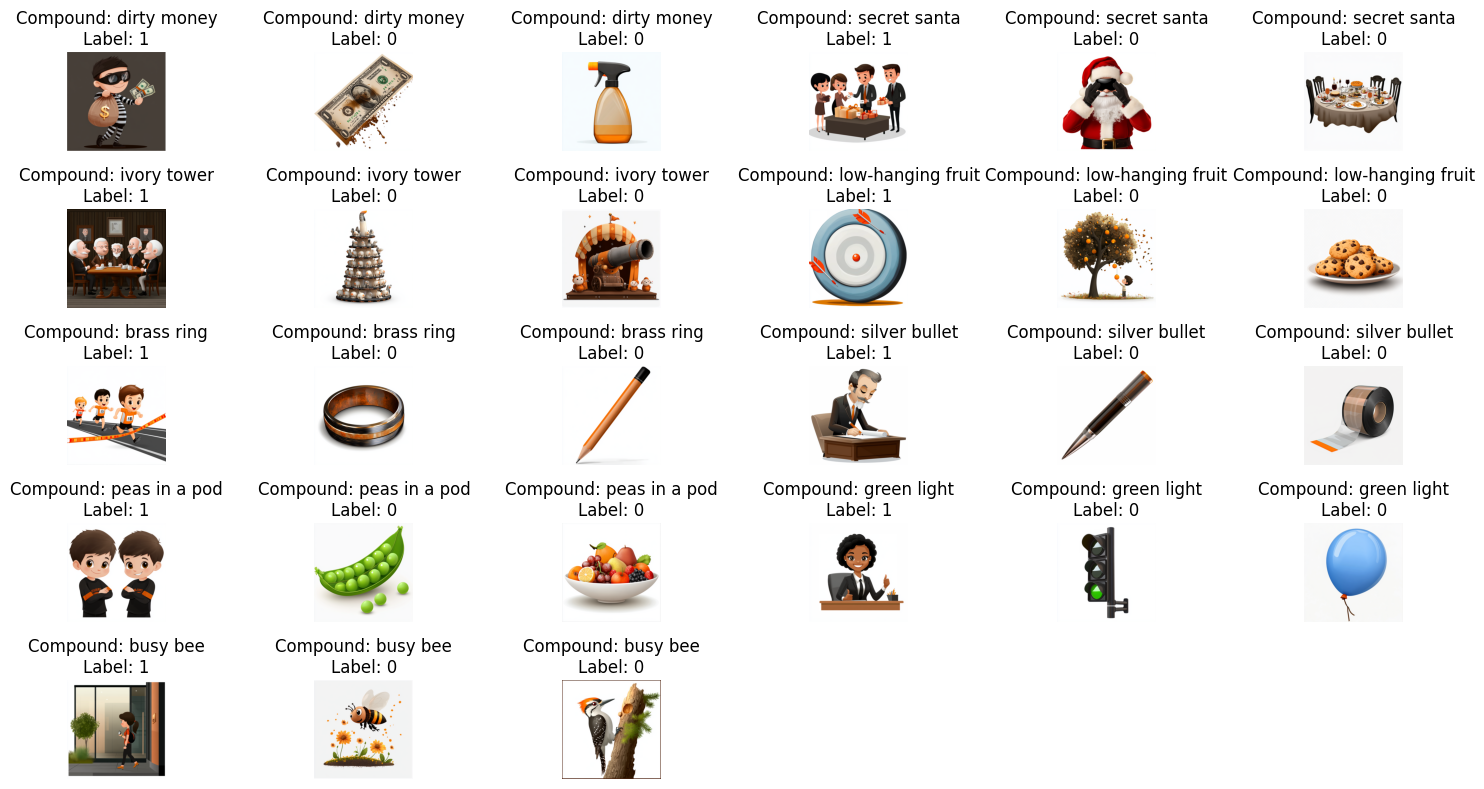

In [ ]:
"""
Visualising dataset.
This taken from the provided boilerplate code.
"""

image_folder = fpath+"/test/images"

def visualise_data(df, image_folder):
    fig, axes = plt.subplots(len(df)//6+1, 6, figsize=(15, 8))
    axes = axes.flatten()

    for idx, row in df.iterrows():
        image_path = os.path.join(image_folder, row['image_name'])
        try:
            img = Image.open(image_path)
            ax = axes[idx]
            ax.imshow(img)
            ax.set_title(f"Compound: {row['compound']}\nLabel: {row['label']}")
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

    # Hide any empty subplots (those beyond the dataset size)
    for idx in range(len(df), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

visualise_data(test_df, fpath+"/test/images")


In [ ]:
"""
Defining a function to for evaluation.
This taken from the provided boilerplate code.
"""

def evaluate(df):
    metrics = {
        "accuracy": accuracy_score(df["label"], df["prediction"]),
        "precision": precision_score(df["label"], df["prediction"]),
        "recall": recall_score(df["label"], df["prediction"]),
        "f1_score": f1_score(df["label"], df["prediction"])
    }
    return metrics

In [ ]:
"""
Checking for empty image names
"""
temp = test_df.copy()
temp['image_name_stripped'] = temp['image_name'].str.strip().str.lower()
suspicious_rows = temp[temp['image_name_stripped'].isin(['', 'nan', 'none'])]
print(suspicious_rows)


Empty DataFrame
Columns: [compound, sentence_type, sentence, image_name, image_caption, label, image_name_stripped]
Index: []


## 2) NLP Exploratory Data Analysis for text data

In [ ]:
## Step 1: NLP Exploratory Data Analysis (Same as before)

def nlp_eda(df):
    # Label distribution
    label_counts = df['label'].value_counts()
    print("Label Distribution:\n", label_counts)
    label_counts.plot(kind='bar', title='Label Distribution')
    plt.show()

    # Text length analysis
    df['text_length'] = df['sentence'].apply(len)
    df.boxplot(column='text_length', by='label', grid=False)
    plt.title('Text Length by Label')
    plt.suptitle('')
    plt.show()


Label Distribution:
 label
0    154
1     77
Name: count, dtype: int64


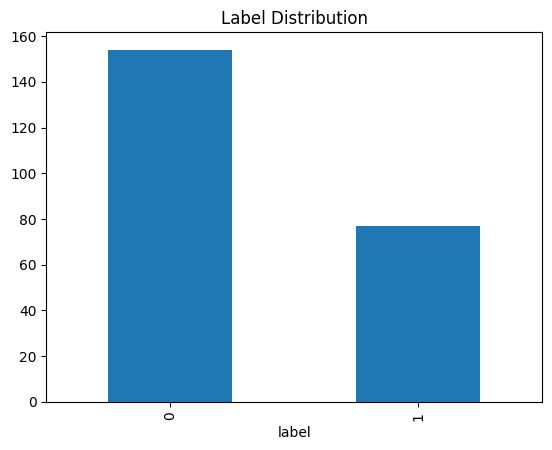

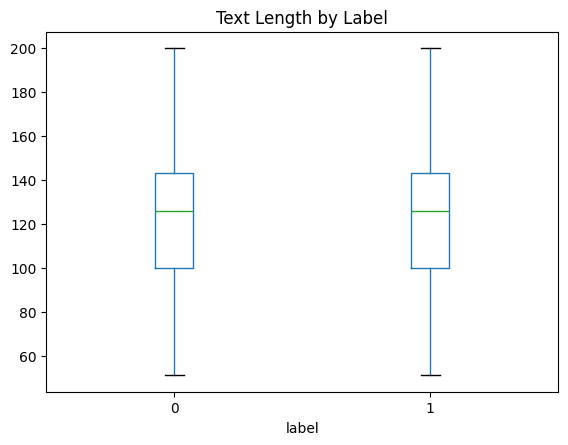

In [ ]:
  nlp_eda(train_df)

## 3) Zero-Shot Prediction

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Loading the CLIP model and the associated preprocessing
model, preprocess = clip.load("ViT-B/32", device=device)

def zero_shot_clip_classification(image_path: str, candidate_texts: list):
    """
    Given an image path and a list of candidate texts,
    returns the text that has the highest similarity to the image.
    """
    # Loading and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Tokenizing candidate text prompts
    text_tokens = clip.tokenize(candidate_texts).to(device)

    # Encoding the image and the text using CLIP
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_tokens)

    # Normalizing the embeddings
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Computing cosine similarity between the image and each text prompt
    similarity_scores = (image_features @ text_features.T).squeeze(0)

    # Picking the text prompt with the highest similarity score
    best_idx = similarity_scores.argmax().item()
    best_text = candidate_texts[best_idx]
    return best_text

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 41.1MiB/s]


In [ ]:
"""
This function applies zero-shot CLIP classification to each row in the dataframe and
returns the dataframe with a new column 'prediction'.
"""
def zero_shot_clip_on_dataset(df, image_folder):
    # Defining candidate text prompts
    candidate_texts = ["This is an idiomatic usage", "This is a literal usage"]

    predictions = []
    for i, row in df.iterrows():
        image_path = os.path.join(image_folder, row["image_name"])

        # Getting the text prompt that best matches the image
        best_text = zero_shot_clip_classification(image_path, candidate_texts)

        # Converting the best text to a label (1 for idiomatic, 0 for literal)
        if best_text == "This is an idiomatic usage":
            pred_label = 1
        else:
            pred_label = 0

        predictions.append(pred_label)

    df["prediction"] = predictions
    return df

In [ ]:

test_df = zero_shot_clip_on_dataset(test_df, fpath+"/test/images")
print(evaluate(test_df))


{'accuracy': 0.8148148148148148, 'precision': 0.7, 'recall': 0.7777777777777778, 'f1_score': 0.7368421052631579}


## 4) LLM based data augmentation to address class imbalance

In [ ]:
"""
Google Gemini API
Removed for privacy reasons
"""
apiKey = ""

In [ ]:

def augment_image(image_name,input_dir='./task2/train/images',output_dir='./task2/train/images'):
    """
    Performs simple random transformations on an image and saves it under a new file name.
    Returns the new image file name.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Construct the full path to the original image
    input_path = os.path.join(input_dir, image_name)

    # Open the image (convert to RGB to avoid issues with some modes like RGBA)
    image = Image.open(input_path).convert('RGB')

    # 1. Random Horizontal Flip
    if random.random() < 0.5:
        image = ImageOps.mirror(image)

    # 2. Random Rotation (0, 90, 180, or 270 degrees)
    angle = random.choice([0, 90, 180, 270])
    image = image.rotate(angle, expand=True)

    # 3. Random Brightness
    enhancer = ImageEnhance.Brightness(image)
    factor = random.uniform(0.8, 1.2)  # 80% to 120% brightness
    image = enhancer.enhance(factor)

    # Create a new file name
    base_name, ext = os.path.splitext(image_name)
    new_image_name = f"{base_name}_aug_{uuid.uuid4().hex[:6]}{ext}"

    # Save the augmented image
    output_path = os.path.join(output_dir, new_image_name)
    image.save(output_path)

    return new_image_name



In [ ]:
"""
Augmenting data for the minority class using a Google Gemini.
Additionally, performing image augmentation so that each new text sample has a corresponding
transformed image. The function generates enough new samples so that the minority class
size approaches the majority class size, subject to max_requests.
"""

def augment_data_with_logging(df, api_key, max_requests=50):

    # Converting image_name column to string to avoid path join errors
    df['image_name'] = df['image_name'].astype(str)

    # Configuring LLM
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel('gemini-1.5-flash')

    # Identifing minority and majority
    minority_df = df[df['label'] == 1].copy()
    majority_df = df[df['label'] == 0].copy()

    minority_count = len(minority_df)
    majority_count = len(majority_df)

    if minority_count >= majority_count:
        print("No augmentation needed: minority class is not smaller than the majority.")
        return pd.DataFrame()

    # Calculating how many total new samples needed to match the majority class
    needed_new_samples = majority_count - minority_count
    print(f"Minority count: {minority_count}, Majority count: {majority_count}")
    print(f"Need ~{needed_new_samples} new samples to match the majority class.")

    # Shuffling minority_df for random selection
    minority_df = minority_df.sample(frac=1).reset_index(drop=True)

    augmented = []
    request_count = 0

    # Iterating through the minority rows in a cycle until we reach needed_new_samples or max_requests
    idx = 0  # index for cycling through minority_df
    print(f"\n{'='*40}\nStarting data augmentation (max {max_requests} requests)\n{'='*40}")

    while len(augmented) < needed_new_samples and request_count < max_requests:
        row = minority_df.iloc[idx]
        compound = row['compound']
        original_image_name = row['image_name']

        try:
            # Building the prompt
            prompt = f"Create a natural sentence using '{compound}' metaphorically:"
            print(f"\n[{request_count+1}/{max_requests}] Generating for compound: {compound}")
            print(f"Prompt: {prompt}")

            response = model.generate_content(prompt)
            new_sentence = response.text.strip()
            print(f"Generated: {new_sentence}")

            # IMAGE AUGMENTATION
            # Performing random transformations on the original image
            # Passsing the correct directories for input and output
            new_image_name = augment_image(
                original_image_name,
                input_dir='./task2/train/images',
                output_dir='./task2/train/images'
            )

            # Storing the augmented sample
            augmented.append({
                'compound': compound,
                'sentence_type': row['sentence_type'],
                'sentence': new_sentence,       # new text from LLM
                'image_name': new_image_name,   # new augmented image file
                'image_caption': row['image_caption'],  # can keep the same caption or modify if needed
                'label': 1  # explicitly setting label=1 for minority class
            })
            print("Added to augmentation list")

            request_count += 1

            # Simple delay to avoid hitting rate limits too quickly
            delay = random.uniform(2, 5)
            print(f"Waiting {delay:.1f}s...")
            time.sleep(delay)

        except Exception as e:
            print(f"Error: {str(e)}")
            # If there's an error, just skip this iteration

        # Move to next row in minority_df
        idx = (idx + 1) % len(minority_df)

    print(f"\n{'='*40}\nAugmentation complete")
    print(f"Total new samples generated: {len(augmented)}")

    if len(augmented) > 0:
        print("\nExample generated entries:")
        for i, entry in enumerate(augmented[:3], 1):
            print(f"{i}. {entry['compound']} | {entry['sentence']} | {entry['image_name']}")

    return pd.DataFrame(augmented)


In [ ]:
print("Original dataset size:", len(train_df))

augmented_data = augment_data_with_logging(
    train_df,
    api_key=apiKey,
    max_requests=77
)

print("\nAugmented data preview:")
print(augmented_data[['compound', 'sentence', 'image_name']].head())

train_df = pd.concat([train_df, augmented_data], ignore_index=True)
print("\nNew dataset size:", len(train_df))

Original dataset size: 231
Minority count: 77, Majority count: 154
Need ~77 new samples to match the majority class.

Starting data augmentation (max 77 requests)

[1/77] Generating for compound: bad apple
Prompt: Create a natural sentence using 'bad apple' metaphorically:
Generated: One bad apple spoiled the whole team's morale.
Added to augmentation list
Waiting 3.0s...

[2/77] Generating for compound: big cheese
Prompt: Create a natural sentence using 'big cheese' metaphorically:
Generated: He's the big cheese around here, everyone defers to his opinion.
Added to augmentation list
Waiting 3.4s...

[3/77] Generating for compound: cold turkey
Prompt: Create a natural sentence using 'cold turkey' metaphorically:
Generated: She decided to quit social media cold turkey, deleting all her accounts without warning.
Added to augmentation list
Waiting 3.1s...

[4/77] Generating for compound: black box
Prompt: Create a natural sentence using 'black box' metaphorically:
Generated: The jury was 

In [ ]:
train_df.head()

compound sentence_type  \
0  hot potato     idiomatic   
1  hot potato     idiomatic   
2  hot potato     idiomatic   
3  act of god     idiomatic   
4  act of god     idiomatic   

                                            sentence       image_name  \
0  The pipeline is set to create a human rights d...  46916305307.png   
1  The pipeline is set to create a human rights d...  00316911039.png   
2  The pipeline is set to create a human rights d...  71196374341.png   
3  Whether an event is intentional, accidental or...  80127117511.png   
4  Whether an event is intentional, accidental or...  51312988406.png   

                                       image_caption  label  text_length  
0  The image depicts two cartoon-style characters...      1        143.0  
1  The image depicts an oven with a large potato ...      0        143.0  
2  The image depicts an old, rolled-up parchment ...      0        143.0  
3  The image depicts a scene where a large tree h...      1        144.0  
4  The image depicts a whimsical scene featuring ...      0        144.0

Label Distribution:
 label
1    154
0    154
Name: count, dtype: int64


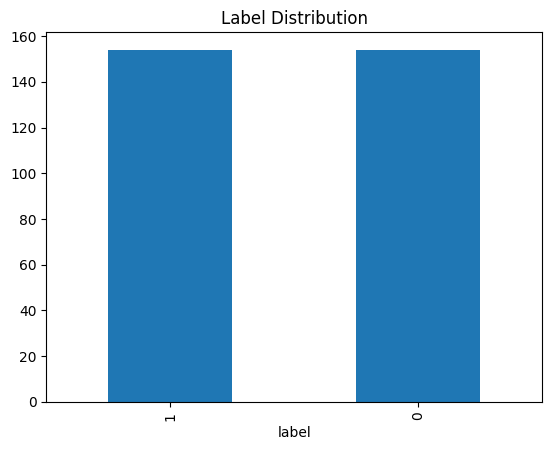

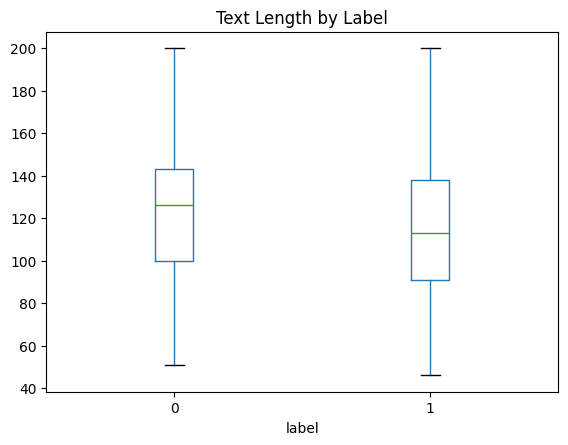

In [ ]:
nlp_eda(train_df)

In [ ]:
test_df.head()

compound sentence_type  \
0   dirty money     idiomatic   
1   dirty money     idiomatic   
2   dirty money     idiomatic   
3  secret santa     idiomatic   
4  secret santa     idiomatic   

                                            sentence       image_name  \
0  When dirty money disappears offshore, it becom...  08230960409.png   
1  When dirty money disappears offshore, it becom...  46913780614.png   
2  When dirty money disappears offshore, it becom...  58491774071.png   
3  She got very annoyed when some wag got her a p...  12319434549.png   
4  She got very annoyed when some wag got her a p...  05850548023.png   

                                       image_caption  label  prediction  
0  The image depicts a cartoon character dressed ...      1           1  
1  The image depicts a one-dollar bill with the p...      0           0  
2  The image depicts a spray bottle, commonly use...      0           0  
3  The image depicts a group of four people, two ...      1           1  
4  The image depicts a person dressed in a Santa ...      0           1

## 5) Fine-tuning CLIP

In [ ]:
# Step 1: Dataset and DataLoader
class ImageDataset(Dataset):
    def __init__(self, df, image_folder, transform):
        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform
        self.valid_indices = self._validate_image_paths()

    def _validate_image_paths(self):
        valid_indices = []
        for idx in range(len(self.df)):
            image_path = os.path.join(self.image_folder, self.df.iloc[idx]["image_name"])
            if os.path.exists(image_path):
                valid_indices.append(idx)
            else:
                print(f"Warning: Missing image {image_path}")
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        row = self.df.iloc[actual_idx]
        image_path = os.path.join(self.image_folder, row["image_name"])
        label = row["label"]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

def create_dataloader(df, image_folder, transform, batch_size=32, shuffle=True):
    dataset = ImageDataset(df, image_folder, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

In [ ]:
# Model Class with AMP Compatibility
class ClipFineTuneModel(nn.Module):
    def __init__(self, clip_model, num_classes=2, hidden_dim=512, unfreeze_layers=4):
        super().__init__()
        self.clip_model = clip_model
        self.unfreeze_layers = unfreeze_layers

        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # Unfreeze last N transformer blocks
        if unfreeze_layers > 0:
            for param in self.clip_model.visual.transformer.resblocks[-unfreeze_layers:].parameters():
                param.requires_grad = True

        # Classifier head (kept in FP32)
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim),
            nn.Linear(self.clip_model.visual.output_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, images):
        # AMP handles dtype automatically
        image_features = self.clip_model.encode_image(images)
        return self.classifier(image_features)

In [ ]:
def train_clip_finetune(model, train_loader, val_loader, epochs=10, lr=1e-4, device='cuda', patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW([
        {'params': model.classifier.parameters(), 'lr': lr},
        {'params': model.clip_model.parameters(), 'lr': lr/10}
    ], weight_decay=0.01)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=patience, verbose=True
    )

    # Updated scaler initialization
    scaler = GradScaler()
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    # Initializing early stopping counter
    no_improve = 0
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # AMP context with device type specified
            with autocast(device_type=device):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                'loss': train_loss / len(train_loader),
                'acc': 100. * correct / total
            })

        # Validation
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                images, labels = images.to(device), labels.to(device)
                with autocast(device_type=device):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)

        # Calculate metrics
        train_acc = 100. * correct / total
        val_acc = 100. * val_correct / val_total

        # Update history
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Scheduler and early stopping
        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            no_improve = 0
        else:
            no_improve += 1

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {history['train_loss'][-1]:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {history['val_loss'][-1]:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")

        if no_improve >= patience * 2:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load('best_model.pth'))
    return model, history

In [ ]:
# Step 4: Evaluation Function
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type=device):
                outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds)
    }

In [ ]:
# Main Execution

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP and convert to FP32 if on CUDA
model_clip, preprocess = clip.load("ViT-B/32", device=device)
if device == "cuda":
  model_clip = model_clip.float()



train_loader = create_dataloader(train_df, os.path.join(fpath, "train/images"), preprocess)
val_loader = create_dataloader(val_df, os.path.join(fpath, "val/images"), preprocess, shuffle=False)
test_loader = create_dataloader(test_df, os.path.join(fpath, "test/images"), preprocess, shuffle=False)

# Initialize model
model = ClipFineTuneModel(
        model_clip,
        num_classes=2,
        hidden_dim=512,
        unfreeze_layers=4
    )

# Train
trained_model, history = train_clip_finetune(
        model,
        train_loader,
        val_loader,
        epochs=20,
        lr=3e-5,
        patience=3,
        device=device
    )

save_path = '/content/drive/MyDrive/advancedAI/finetuned_clip_model.pth'
os.makedirs(os.path.dirname(save_path), exist_ok=True)


torch.save(trained_model.state_dict(), save_path)
print(f"Finetuned model saved to {save_path}")


Epoch 1/20 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



Epoch 1 Summary:
Train Loss: 0.6911 | Train Acc: 52.27%
Val Loss: 0.6460 | Val Acc: 70.37%
Current LR: 3.00e-05


Epoch 2/20 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



Epoch 2 Summary:
Train Loss: 0.5838 | Train Acc: 81.49%
Val Loss: 0.5961 | Val Acc: 77.78%
Current LR: 3.00e-05


Epoch 3/20 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



Epoch 3 Summary:
Train Loss: 0.5207 | Train Acc: 83.44%
Val Loss: 0.5595 | Val Acc: 77.78%
Current LR: 3.00e-05


Epoch 4/20 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



Epoch 4 Summary:
Train Loss: 0.4315 | Train Acc: 87.34%
Val Loss: 0.4876 | Val Acc: 88.89%
Current LR: 3.00e-05


Epoch 5/20 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



Epoch 5 Summary:
Train Loss: 0.3503 | Train Acc: 90.91%
Val Loss: 0.4597 | Val Acc: 88.89%
Current LR: 3.00e-05


Epoch 6/20 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



Epoch 6 Summary:
Train Loss: 0.2776 | Train Acc: 93.83%
Val Loss: 0.4227 | Val Acc: 81.48%
Current LR: 3.00e-05


Epoch 7/20 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]



Epoch 7 Summary:
Train Loss: 0.1952 | Train Acc: 96.10%
Val Loss: 0.4194 | Val Acc: 77.78%
Current LR: 3.00e-05


Epoch 8/20 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



Epoch 8 Summary:
Train Loss: 0.1324 | Train Acc: 98.70%
Val Loss: 0.4461 | Val Acc: 74.07%
Current LR: 1.50e-05


Epoch 9/20 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



Epoch 9 Summary:
Train Loss: 0.0958 | Train Acc: 99.68%
Val Loss: 0.4476 | Val Acc: 74.07%
Current LR: 1.50e-05


Epoch 10/20 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]



Epoch 10 Summary:
Train Loss: 0.0782 | Train Acc: 99.68%
Val Loss: 0.4534 | Val Acc: 81.48%
Current LR: 1.50e-05
Early stopping at epoch 10
Finetuned model saved to /content/drive/MyDrive/advancedAI/finetuned_clip_model.pth


In [ ]:
# Evaluate
metrics = evaluate_model(trained_model, test_loader, device)
print("\nFinal Test Metrics:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")

Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Final Test Metrics:
Accuracy: 0.9259
Precision: 1.0000
Recall: 0.7778
F1 Score: 0.8750


## 6) Displaying predictions on custom images and test set

In [ ]:
def predict_best_image_finetuned(model_path: str, text_prompt: str, image_paths: list, device: str = None):

    import torch
    import clip
    import torch.nn as nn
    from PIL import Image

    # Determine device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load base CLIP model and preprocessing
    model_clip, preprocess = clip.load("ViT-B/32", device=device)
    if device == "cuda":
        model_clip = model_clip.float()

    # Define the fine-tuned model (as per your training code)
    class ClipFineTuneModel(nn.Module):
        def __init__(self, clip_model, num_classes=2, hidden_dim=512, unfreeze_layers=4):
            super().__init__()
            self.clip_model = clip_model
            self.unfreeze_layers = unfreeze_layers

            # Freeze CLIP parameters
            for param in self.clip_model.parameters():
                param.requires_grad = False

            # Unfreeze last N transformer blocks
            if unfreeze_layers > 0:
                for param in self.clip_model.visual.transformer.resblocks[-unfreeze_layers:].parameters():
                    param.requires_grad = True

            # Classifier head (kept in FP32)
            self.classifier = nn.Sequential(
                nn.LayerNorm(self.clip_model.visual.output_dim),
                nn.Linear(self.clip_model.visual.output_dim, hidden_dim),
                nn.GELU(),
                nn.Dropout(0.3),
                nn.Linear(hidden_dim, num_classes)
            )

        def forward(self, images):
            image_features = self.clip_model.encode_image(images)
            return self.classifier(image_features)

    # Instantiate and load the fine-tuned model
    model = ClipFineTuneModel(model_clip, num_classes=2, hidden_dim=512, unfreeze_layers=4)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Map the text prompt to a target label.
    # (Assuming "idiomatic" corresponds to label 1 and "literal" to label 0)
    prompt_lower = text_prompt.lower()
    if "idiom" in prompt_lower:
        target_label = 1
    elif "literal" in prompt_lower:
        target_label = 0
    else:
        raise ValueError("Text prompt must indicate either 'idiom' or 'literal' usage.")

    # Process each image and compute the probability for the target label.
    target_probs = []
    for img_path in image_paths:
        image = Image.open(img_path).convert("RGB")
        image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(image_input)  # shape: (1,2)
            probs = torch.softmax(logits, dim=1)  # shape: (1,2)
            prob = probs[0, target_label].item()
            target_probs.append(prob)

    # Determine the index of the image with the highest probability for the target label.
    best_index = target_probs.index(max(target_probs))

    return best_index, target_probs




In [ ]:
def display_images_and_best_match(model_path: str,
                                  text_prompt: str,
                                  image_info: list,
                                  device: str = None):

    # Ensure we have exactly 3 images
    if len(image_info) != 3:
        raise ValueError("image_info must contain exactly 3 tuples of (image_path, caption).")

    # Extract just the image paths
    image_paths = [info[0] for info in image_info]

    # Get the best index and probabilities
    best_index, probabilities = predict_best_image_finetuned(model_path, text_prompt, image_paths, device)

    # Creating a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, (ax, (img_path, caption)) in enumerate(zip(axes, image_info)):
        # Loading and displaying image
        image = Image.open(img_path).convert("RGB")
        ax.imshow(image)
        ax.axis("off")

        #  title is set to the probability
        title_text = f"Probability: {probabilities[i]:.3f}"
        ax.set_title(title_text, fontsize=10)

        # drawing a rectangle around the best result
        if i == best_index:
            rect = patches.Rectangle((0, 0), image.size[0], image.size[1],
                                     linewidth=5, edgecolor='red', facecolor='none')
            ax.add_patch(rect)


    plt.suptitle(f"Best Match: Image #{best_index+1} (Text Prompt: '{text_prompt}')",
                 fontsize=12, color='blue')
    plt.tight_layout()
    plt.show()


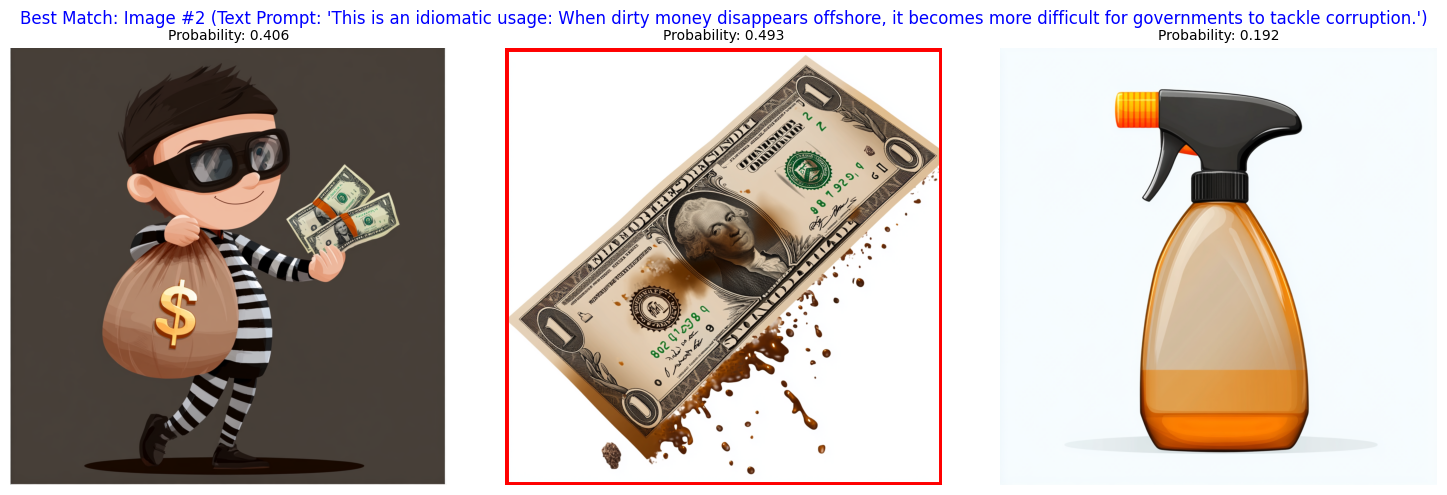

In [ ]:
image_info = [
    ("demot2/1.png", "he image depicts a cartoon character dressed as a burglar or robber. The character is wearing a black and white striped outfit, a black mask, and black shoes. They are holding a large sack with a gold dollar sign on it, indicating that the sack contains money. In their other hand, they are holding two American one-dollar bills. The background is a solid dark color, which makes the character and the items they are holding stand out prominently."),
    ("demot2/2.png", "The image depicts a one-dollar bill with the portrait of George Washington prominently displayed in the center. The bill appears to be partially stained or covered in a brown substance, possibly coffee or another dark liquid. The stains are concentrated around the bottom right corner and spread outward, creating a splattered effect. The bill\'s details, such as the denomination ""1"" and the serial number, are still visible but slightly obscured by the stains. The overall appearance suggests that the bill has been accidentally stained or damaged."),
    ("demot2/3.png", "The image depicts a spray bottle, commonly used for dispensing liquids such as cleaning solutions, disinfectants, or other household products. The bottle is made of a translucent amber-colored plastic, which helps to protect the contents from UV light and prolong their shelf life. The bottle has a trigger-style sprayer mechanism at the top, which consists of a black plastic body with an orange cap. The cap is designed to be pushed down to release the liquid in a fine mist or stream, depending on the position of the trigger. The bottle appears to be filled with a yellowish liquid, suggesting it might be a cleaning solution or a similar product. The overall design is simple and functional, typical of many household cleaning products"),
]
model_path = "/content/drive/MyDrive/advancedAI/finetuned_clip_model.pth"
text_prompt = "This is an idiomatic usage: When dirty money disappears offshore, it becomes more difficult for governments to tackle corruption."

display_images_and_best_match(model_path, text_prompt, image_info)


Compound: brass ring


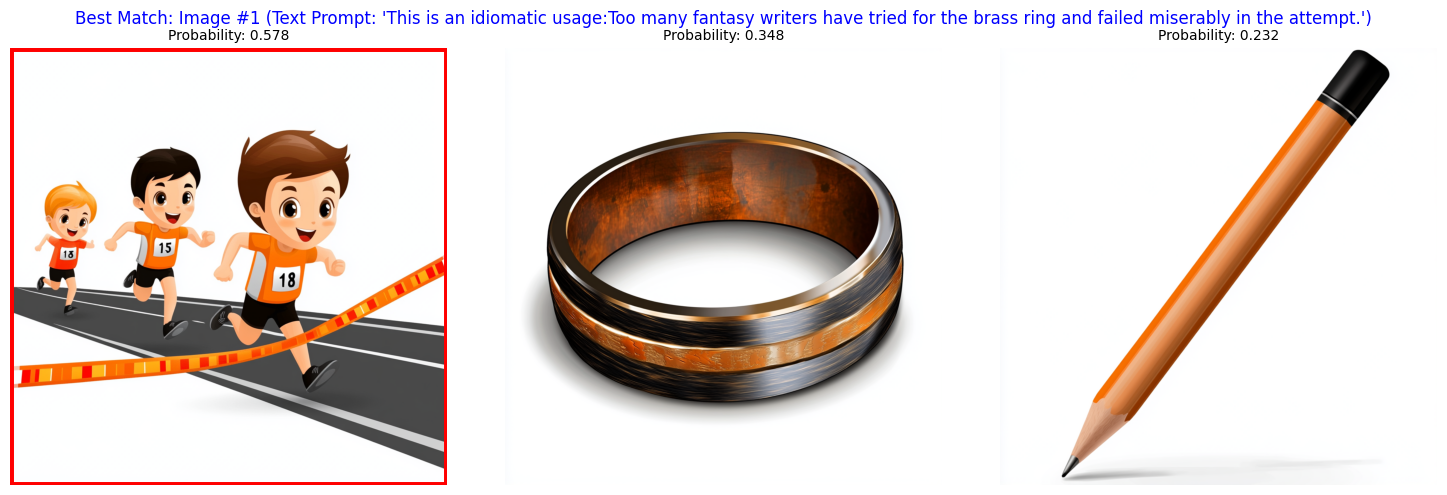

Compound: busy bee


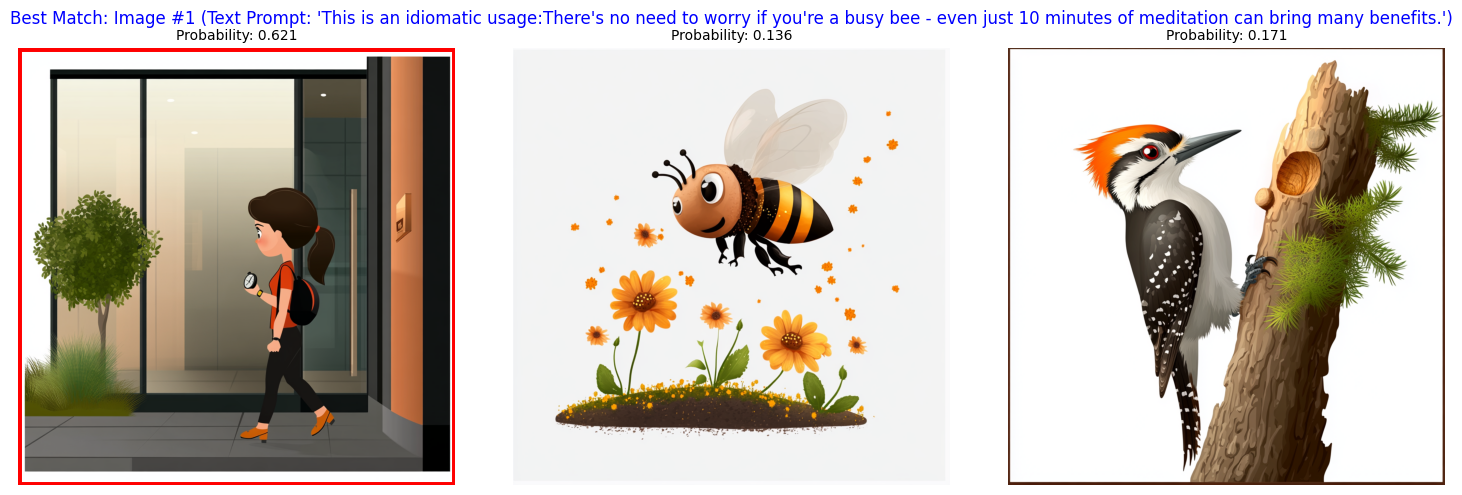

Compound: dirty money


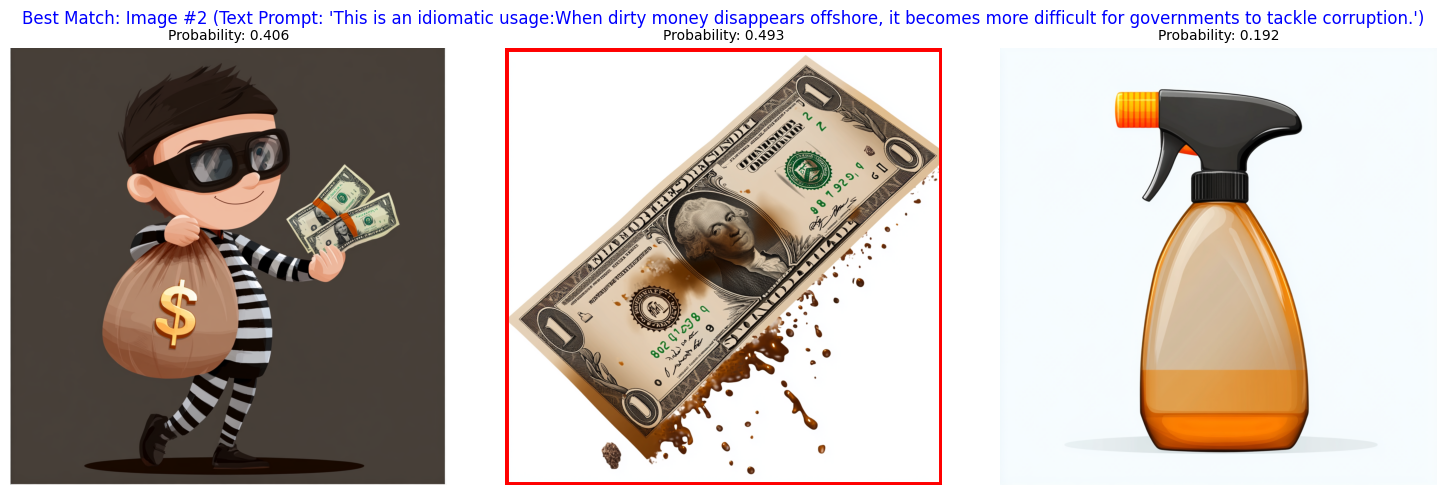

Compound: green light


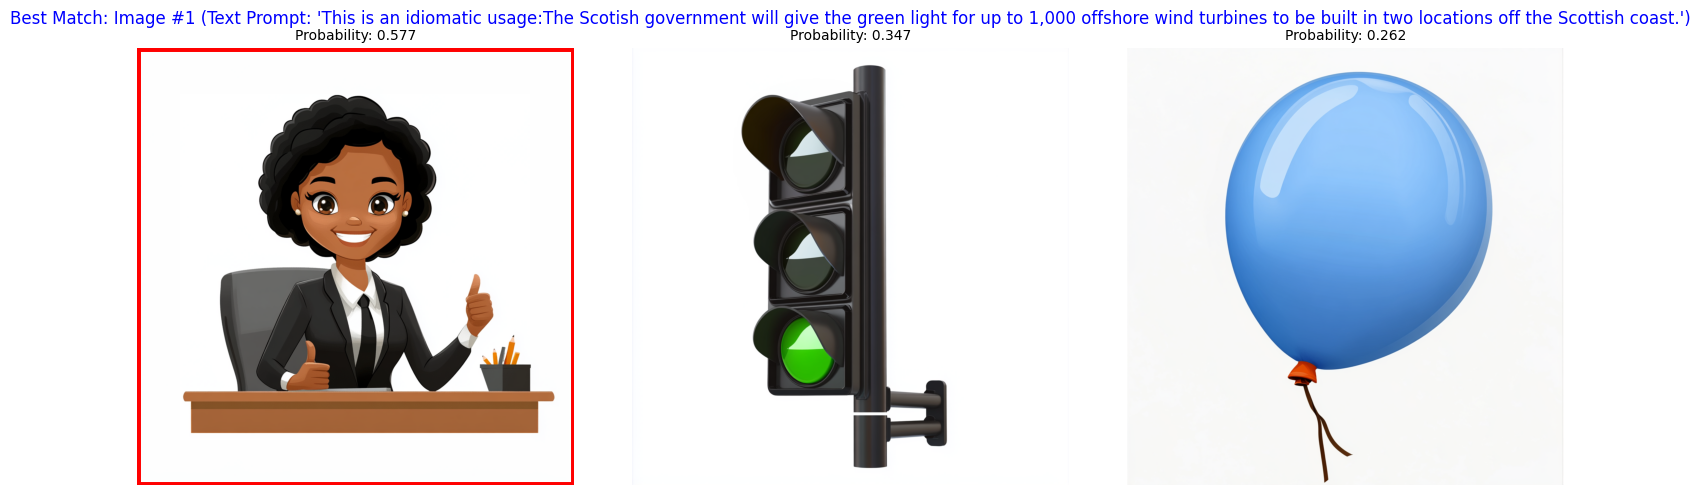

Compound: ivory tower


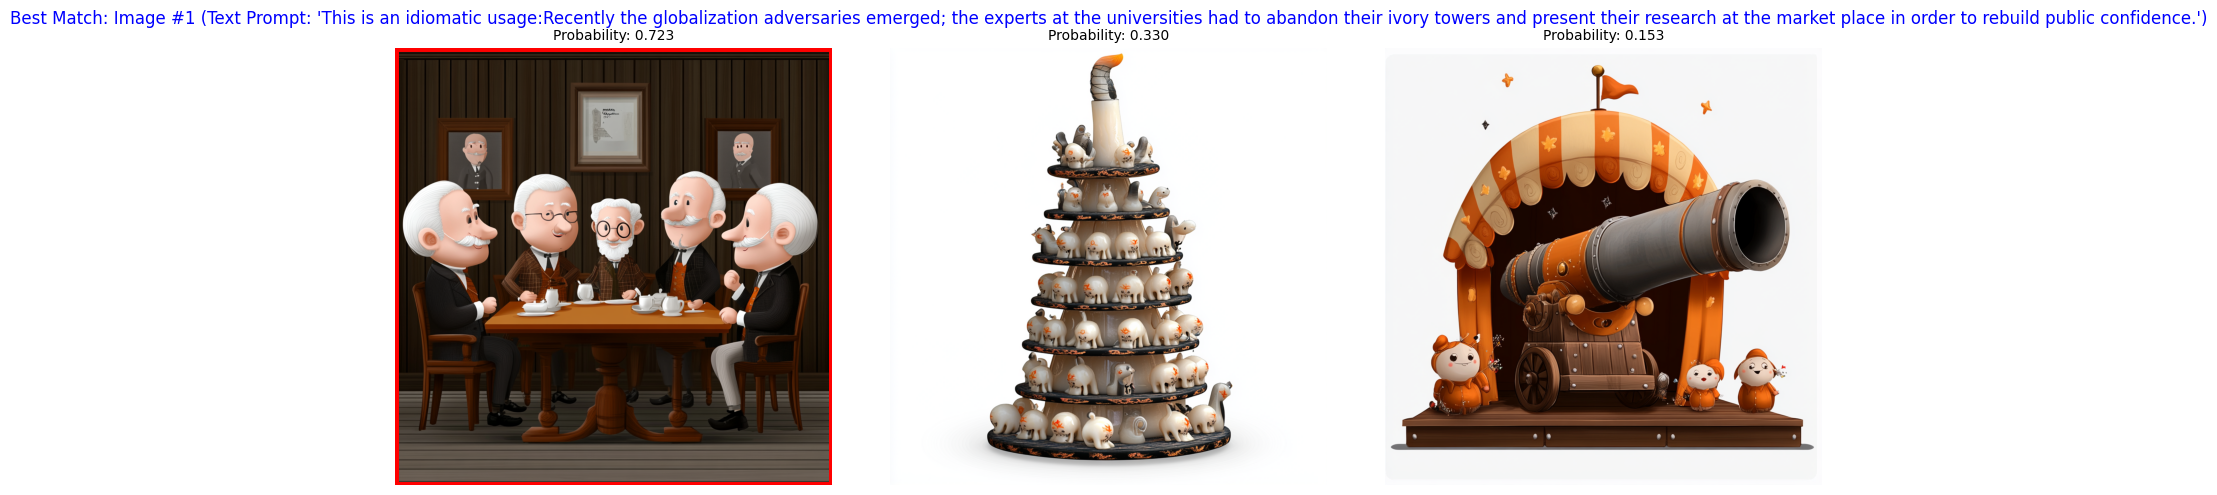

Compound: low-hanging fruit


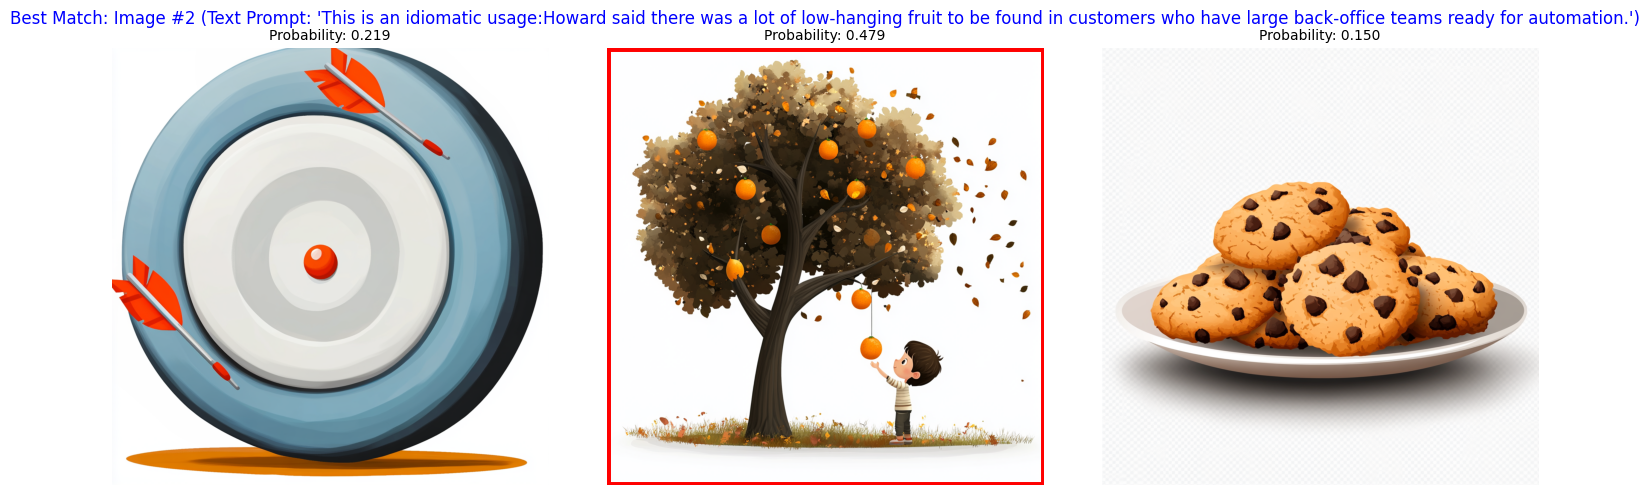

Compound: peas in a pod


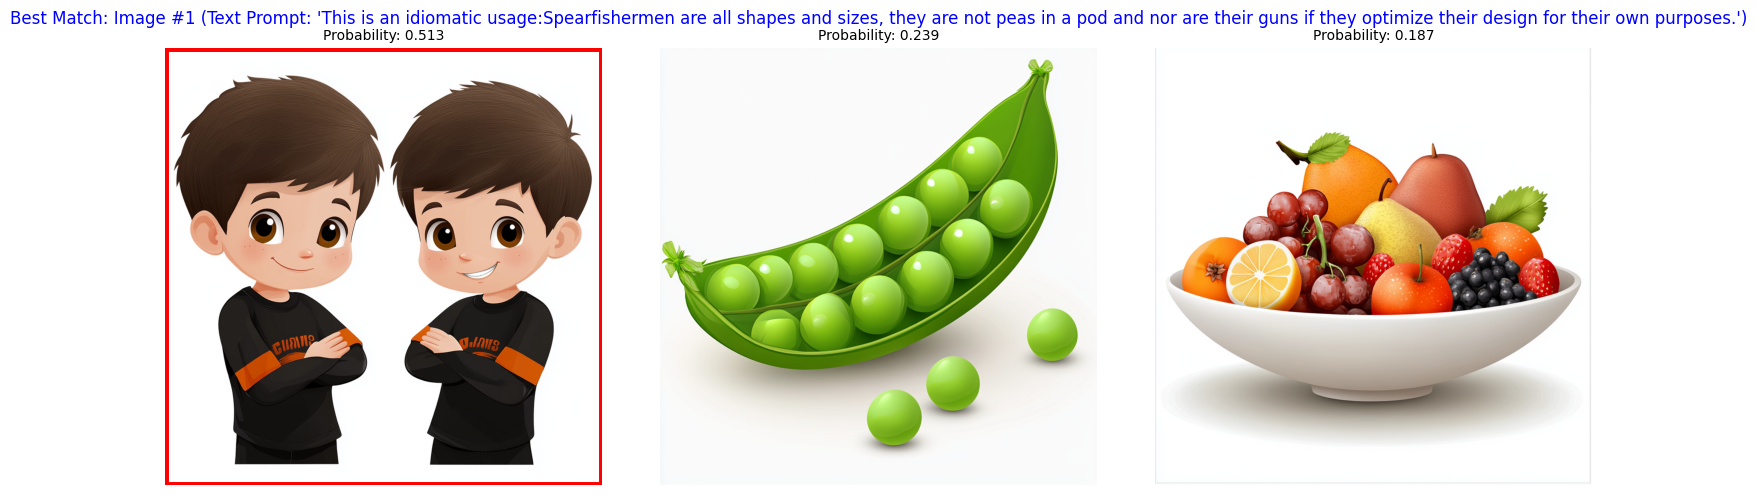

Compound: secret santa


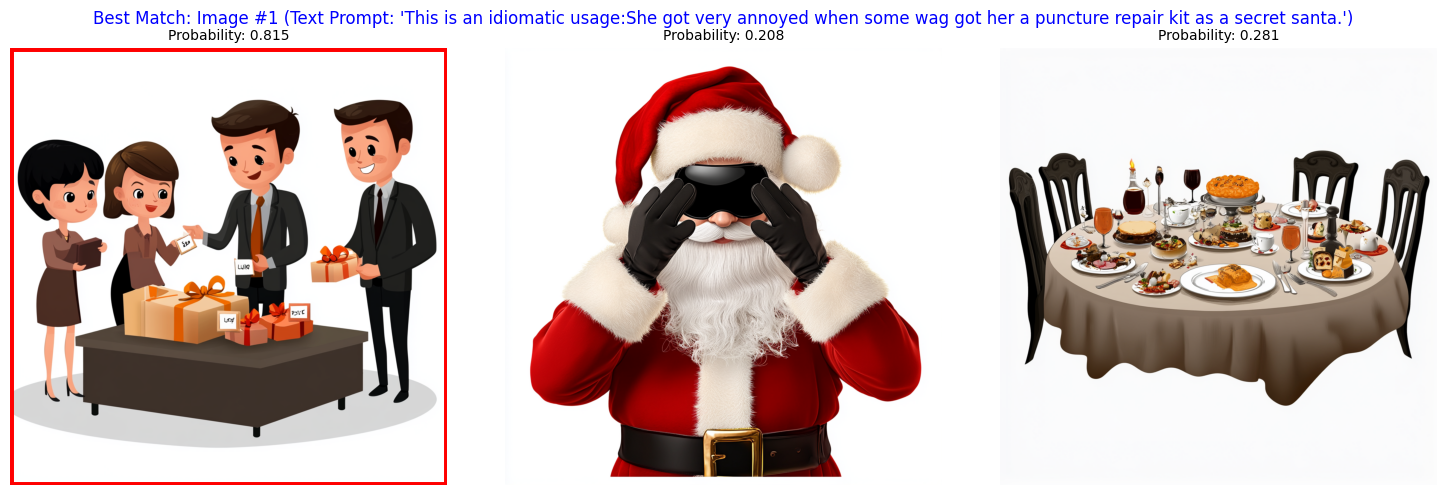

Compound: silver bullet


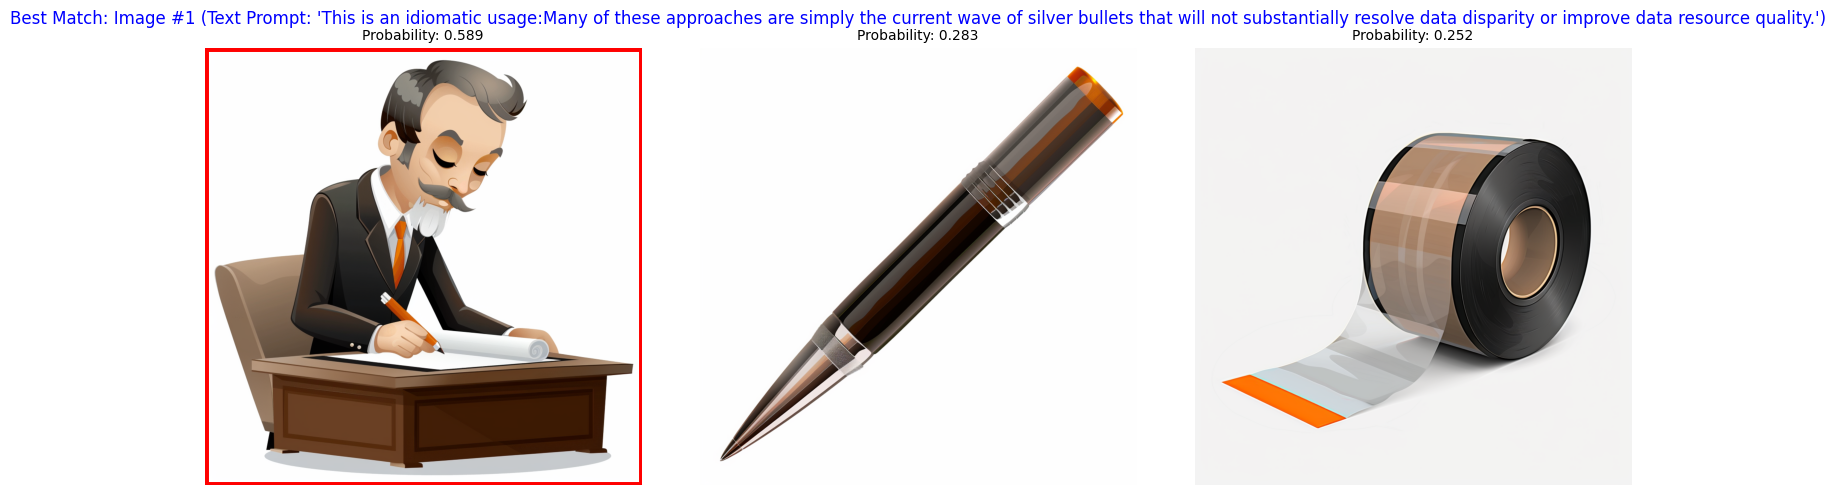

In [ ]:
"""
The below code makes prediction on the whole of test set
"""

text_prompt = "This is an idiomatic usage"
test_image_folder = os.path.join(fpath, "test/images")


grouped = test_df.groupby("compound")

for compound, group in grouped:
    full_sentence = group.iloc[0]["sentence"]
    if len(group) == 3:
        image_info = []
        for _, row in group.iterrows():
            img_path = os.path.join(test_image_folder, row["image_name"])
            caption = row.get("sentence", "")
            image_info.append((img_path, caption))


        print(f"Compound: {compound}")
        display_images_and_best_match(
            model_path=model_path,
            text_prompt=text_prompt +":"+ full_sentence,
            image_info=image_info,
            device=None
        )
    else:
        print(f"Skipping compound '{compound}' - expected 3 images, found {len(group)}.")
